In [1]:
# Python core
from typing import Optional, Callable, TypedDict, Union
from dataclasses import dataclass

# Scientific python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

# Cloud compute
import gcsfs

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import pytorch_lightning as pl

## Consts & config

In [2]:
ZARR = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/OSGB36/all_zarr_int16'

In [3]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'none'

In [4]:
torch.cuda.is_available()

True

# Load satellite data

In [5]:
def get_sat_data(filename: str=ZARR) -> xr.DataArray:
    """Lazily opens the Zarr store on Google Cloud Storage (GCS).
    
    Selects the High Resolution Visible (HRV) satellite channel.
    """
    gcs = gcsfs.GCSFileSystem()
    store = gcsfs.GCSMap(root=filename, gcs=gcs)
    dataset = xr.open_zarr(store, consolidated=True)
    return dataset['stacked_eumetsat_data'].sel(variable='HRV')

In [6]:
%%time
sat_data = get_sat_data()

CPU times: user 1.69 s, sys: 57.9 ms, total: 1.75 s
Wall time: 1.96 s


Caution: Wierdly, plotting `sat_data` at this point causes the code to hang (with no errors messages) when it gets to `enumerate(dataloader)`.  The code hangs even if we first do `sat_data.close(); del sat_data`

In [7]:
sat_data

<xarray.DataArray 'stacked_eumetsat_data' (time: 163079, y: 704, x: 548)>
dask.array<getitem, shape=(163079, 704, 548), dtype=int16, chunksize=(36, 704, 548), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2018-06-01T02:04:00 ... 2019-12-31T22:54:00
    variable  <U6 'HRV'
  * x         (x) int64 -238000 -236000 -234000 -232000 ... 852000 854000 856000
  * y         (y) int64 1222000 1220000 1218000 ... -180000 -182000 -184000

## Simple PyTorch Dataset

We have several TB of satellite data. To keep the GPU fed with data during training, we need to read chunks of data quickly from the Zarr store; and we also want to load data asynchronously.  That is, while the GPU is training on the current batch, the data loader should simultaneously load the _next_ batch from disk.

PyTorch makes this easy!  PyTorch's `DataLoader` spawns multiple worker processes when constructed with `num_workers` set to more than 1.  Each worker process receives a copy of the `SatelliteDataset` object.

There is a small challenge: The code hangs when it gets to `enumerate(dataloader)` if we open the `xarray.DataArray` in the main process and copy that opened `DataArray` to the child processes.  Our solution is to delay the creation of the `DataArray` until _after_ the worker processes have been created.  PyTorch makes this easy by allowing us to pass a `worker_init_fn` to `DataLoader`.  `worker_init_fn` is called on each worker process.  Our `worker_init_fn` just has one job: to call `SatelliteDataset.per_worker_init()` which, in turn, opens the `DataArray`.

This approach achieves read speeds of 600 MB/s from Google Cloud Storage to a single GCP VM with 12 vCPUs (as measured by `nethogs`).

We use `IterableDataset` instead of `Dataset` so `SatelliteDataset` can pre-load the next example from disk and then block (on the `yield`) waiting for PyTorch to read that data.  This allows the worker processes to load the next batch from disk while the main process is training the current batch on the GPU.

We can't pin the memory in each worker process because pinned memory can't be shared across processes.  Instead we ask `DataLoader` to pin the collated batch so that pytorch-lightning can asynchronously load the next batch from pinned CPU memory into GPU memory.

### Timestep numbering:

* t<sub>0</sub> is 'now':  It's the most recent observation.
* t<sub>1</sub> is the first forecast.

In [8]:
Array = Union[np.ndarray, xr.DataArray]

IMAGE_ATTR_NAMES = ('historical_sat_images', 'target_sat_images')

class Sample(TypedDict):
    """Simple class for structuring data for the ML model.
    
    Using typing.TypedDict gives us several advantages:
      1. Single 'source of truth' for the type and documentation of each example.
      2. A static type checker can check the types are correct.

    Instead of TypedDict,, we could use typing.NamedTuple,
    which would provide runtime checks, but, crucially, Tuples are immutable
    so we cannot change the values in the transforms.
    """
    # IMAGES
    # Shape: batch_size, seq_length, width, height
    historical_sat_images: Array
    target_sat_images: Array


class BadData(Exception):
    pass
        

class RandomSquareCrop():
    size: int = 128  #: Size of the cropped image.

    def __call__(self, sample: Sample) -> Sample:
        crop_params = None
        for attr_name in IMAGE_ATTR_NAMES:
            image = sample[attr_name]
            # TODO: Random crop!
            cropped_image = image[..., :self.size, :self.size]
            sample[attr_name] = cropped_image
        return sample


class CheckForBadData():
    def __call__(self, sample: Sample) -> Sample:
        for attr_name in IMAGE_ATTR_NAMES:
            image = sample[attr_name]
            if np.any(image < 0):
                raise BadData(f'{attr_name} has negative values at {image.time}!')
        return sample
    
    
class Normalize():
    HRV_MEAN = 93.23458
    HRV_STD = 115.34247
    def __call__(self, sample: Sample) -> Sample:
        for attr_name in IMAGE_ATTR_NAMES:
            image = sample[attr_name].astype(np.float32)
            image -= Normalize.HRV_MEAN
            image /= Normalize.HRV_STD
            sample[attr_name] = image
        return sample

        
class ToTensor():
    def __call__(self, sample: Sample) -> Sample:
        for key, value in sample.items():
            if isinstance(value, xr.DataArray):
                value = value.values
            sample[key] = torch.from_numpy(value)
        return sample

In [21]:
@dataclass
class SatelliteDataset(torch.utils.data.IterableDataset):
    total_dataset_len: int  #: The total number of timesteps in the entire dataset.
    history_len: int = 1  #: The number of timesteps of 'history' to load.
    forecast_len: int = 1  #: The number of timesteps of 'forecast' to load.
    transform: Optional[Callable] = None
    n_samples_per_epoch_total: int = 1_000_000
    
    def __post_init__(self):
        #: Total sequence length of each sample.
        self.total_seq_len = self.history_len + self.forecast_len
        
        #: Effective length of entire dataset.
        self.effective_dataset_len = self.total_dataset_len - self.total_seq_len

    def per_worker_init(self, n_workers: int=1) -> None:
        """Called by worker_init_fn on each copy of SatelliteDataset after the worker process has been spawned."""
        self.data_array = get_sat_data()
        self.n_samples_per_epoch_per_worker = self.n_samples_per_epoch_total // n_workers
        # Each worker must have a different seed for its random number generator.
        # Otherwise all the workers will output exactly the same data!
        seed = torch.initial_seed()
        self.rng = np.random.default_rng(seed=seed)
    
    def __iter__(self):
        for _ in range(self.n_samples_per_epoch_per_worker):
            # TODO: Ensure images are contiguous in time.
            start_idx = self.rng.integers(low=0, high=self.effective_dataset_len, dtype=np.uint32)
            end_idx = start_idx + self.total_seq_len
            sat_images = self.data_array.isel(time=slice(start_idx, end_idx))
            sample = Sample(
                historical_sat_images=sat_images[:self.history_len],
                target_sat_images=sat_images[self.history_len:])
            if self.transform:
                try:
                    sample = self.transform(sample)
                except BadData as e:
                    print(e)
                    continue
            yield sample


def worker_init_fn(worker_id):
    """Configures each dataset worker process.
    
    Just has one job!  To call SatelliteDataset.per_worker_init().
    """
    # get_worker_info returns information specific to each worker process.
    worker_info = torch.utils.data.get_worker_info()
    if worker_info is None:
        print('worker_info is None!')
    else:
        dataset_obj = worker_info.dataset  # The Dataset copy in this worker process.
        dataset_obj.per_worker_init(n_workers=worker_info.num_workers)


torch.manual_seed(42)    

dataset = SatelliteDataset(
    total_dataset_len=len(sat_data),
    transform=transforms.Compose([
        RandomSquareCrop(),
        #CheckForBadData(),
        #Normalize(),  # TODO: Normalise on the GPU.
        ToTensor(),
    ]),
)

In [33]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    num_workers=20,  # timings:  4=13.8s; 8=11.6; 10=11.3s; 11=11.5s; 12=12.6s.  10=3it/s
    worker_init_fn=worker_init_fn,
    pin_memory=True
)

In [34]:
%%time
for i, batch in enumerate(dataloader):
    print(i, batch['historical_sat_images'].shape)
    if i > 2:
        break

0 torch.Size([8, 1, 128, 128])
1 torch.Size([8, 1, 128, 128])
2 torch.Size([8, 1, 128, 128])
3 torch.Size([8, 1, 128, 128])
CPU times: user 58.6 ms, sys: 970 ms, total: 1.03 s
Wall time: 18 s


In [35]:
batch['historical_sat_images'].shape

torch.Size([8, 1, 128, 128])

In [36]:
batch['target_sat_images'].shape

torch.Size([8, 1, 128, 128])

In [37]:
batch['historical_sat_images'].dtype

torch.int16

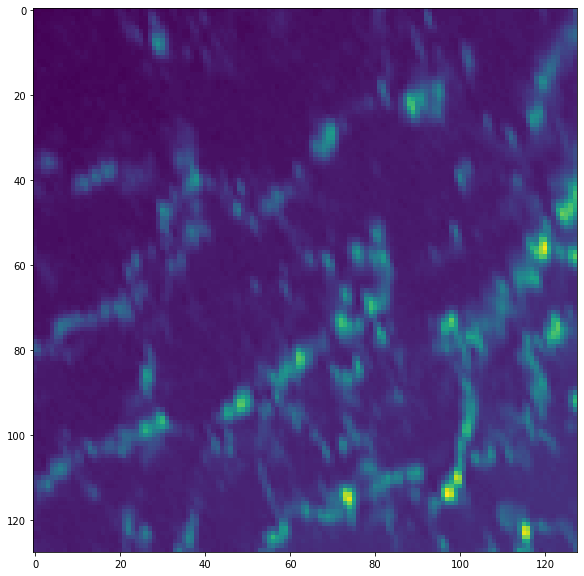

In [38]:
plt.imshow(batch['historical_sat_images'][0, 0])

# Simple ML model

In [39]:
def normalise_images_in_model(images, device):    
    SAT_IMAGE_MEAN = torch.tensor(93.23458, dtype=torch.float, device=device)
    SAT_IMAGE_STD = torch.tensor(115.34247, dtype=torch.float, device=device)
    
    images = images.float()
    images -= SAT_IMAGE_MEAN
    images /= SAT_IMAGE_STD
    return images

In [40]:
CHANNELS = 32
KERNEL = 3


class LitAutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.encoder_conv1 = nn.Conv2d(in_channels=1, out_channels=CHANNELS//2, kernel_size=KERNEL)
        self.encoder_conv2 = nn.Conv2d(in_channels=CHANNELS//2, out_channels=CHANNELS, kernel_size=KERNEL)
        self.encoder_conv3 = nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=KERNEL)
        self.encoder_conv4 = nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=KERNEL)

        self.maxpool = nn.MaxPool2d(kernel_size=KERNEL)
        
        self.decoder_conv1 = nn.ConvTranspose2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=KERNEL)
        self.decoder_conv2 = nn.ConvTranspose2d(in_channels=CHANNELS, out_channels=CHANNELS//2, kernel_size=KERNEL)
        self.decoder_conv3 = nn.ConvTranspose2d(in_channels=CHANNELS//2, out_channels=CHANNELS//2, kernel_size=KERNEL)
        self.decoder_conv4 = nn.ConvTranspose2d(in_channels=CHANNELS//2, out_channels=1, kernel_size=KERNEL)
        
    def forward(self, x):
        images = x['historical_sat_images']
        images = normalise_images_in_model(images, self.device)
        
        # Pass data through the network :)
        # ENCODER
        out = F.relu(self.encoder_conv1(images))        
        out = F.relu(self.encoder_conv2(out))       
        out = F.relu(self.encoder_conv3(out))
        out = F.relu(self.encoder_conv4(out))
        out = self.maxpool(out)
        
        # DECODER
        out = F.relu(self.decoder_conv1(out))        
        out = F.relu(self.decoder_conv2(out))        
        out = F.relu(self.decoder_conv3(out))
        out = self.decoder_conv4(out)
        
        return out
    
    def _training_or_validation_step(self, batch, is_train_step):
        y_hat = self(batch)
        y = batch['target_sat_images']
        y = normalise_images_in_model(y, self.device)
        y = y[..., 40:-40, 40:-40]  # Due to the CNN stride, the output image is 48 x 48
        loss = F.mse_loss(y_hat, y)
        tag = "Loss/Train" if is_train_step else "Loss/Validation"
        self.log_dict({tag: loss}, on_step=is_train_step, on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._training_or_validation_step(batch, is_train_step=True)
    
    def validation_step(self, batch, batch_idx):
        return self._training_or_validation_step(batch, is_train_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [41]:
model = LitAutoEncoder()

In [42]:
trainer = pl.Trainer(gpus=1, max_epochs=400, terminate_on_nan=False)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [ ]:
%%time
trainer.fit(model, train_dataloader=dataloader)


  | Name          | Type            | Params
--------------------------------------------------
0 | encoder_conv1 | Conv2d          | 160   
1 | encoder_conv2 | Conv2d          | 4.6 K 
2 | encoder_conv3 | Conv2d          | 9.2 K 
3 | encoder_conv4 | Conv2d          | 9.2 K 
4 | maxpool       | MaxPool2d       | 0     
5 | decoder_conv1 | ConvTranspose2d | 9.2 K 
6 | decoder_conv2 | ConvTranspose2d | 4.6 K 
7 | decoder_conv3 | ConvTranspose2d | 2.3 K 
8 | decoder_conv4 | ConvTranspose2d | 145   
--------------------------------------------------
39.6 K    Trainable params
0         Non-trainable params
39.6 K    Total params
0.159     Total estimated model params size (MB)


Epoch 0: : 519it [02:19,  3.73it/s, loss=0.11, v_num=91]  